In [5]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# affected nodes throughout the year: 33/34/163
file_path = "data/data_day300.pkl"
day_num = int(file_path.split('day')[1].split('.')[0])

with open(file_path, "rb") as f:
    data = pickle.load(f)

In [6]:
voltage_norm = data['sch_v']
angle_norm = data['sch_θ']
voltage_attack = data['attack_v']
angle_attack = data['attack_θ']

attack: x37-x61, 09:00-15:15


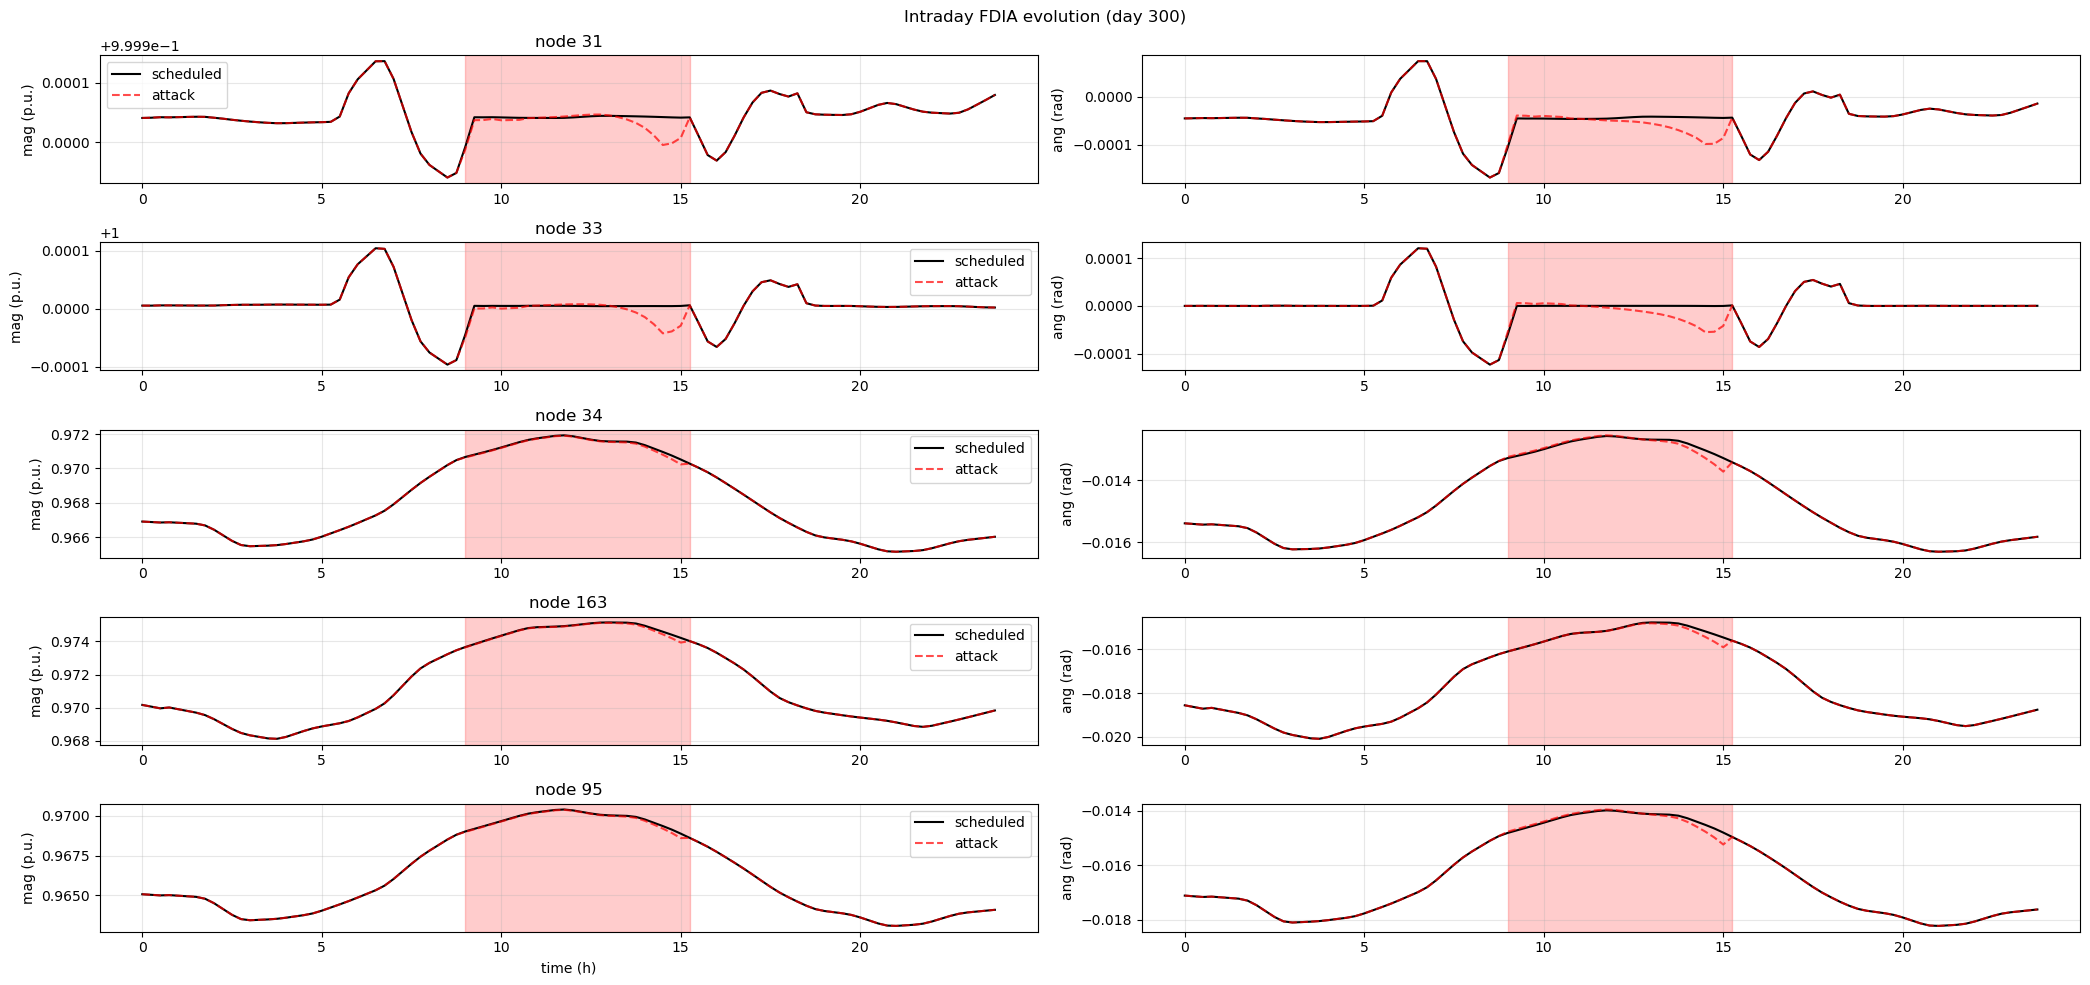

In [7]:
 # timesteps under penetration
attack_keys = sorted(voltage_attack.keys(), key=lambda x: int(x[1:]))
diff_keys = []
for k in attack_keys:
    v_diff = np.abs(voltage_attack[k] - voltage_norm[k])
    θ_diff = np.abs(angle_attack[k] - angle_norm[k])
    if np.max(v_diff) > 1e-6 or np.max(θ_diff) > 1e-6:
        diff_keys.append(k)

attack_steps = [int(k[1:]) for k in diff_keys]
attack_start = min(attack_steps)
attack_end = max(attack_steps)
start = (attack_start - 1) * 15 / 60
end = attack_end * 15 / 60

def hhmm(h):
    return f"{int(h):02d}:{int((h % 1) * 60):02d}"

print(f"attack: x{attack_start}-x{attack_end}, {hhmm(start)}-{hhmm(end)}")

nodes = [31, 33, 34, 163, 95]
all_keys = sorted(voltage_norm.keys(), key=lambda x: int(x[1:]))
timesteps = [int(k[1:]) for k in all_keys]
times = [(t - 1) * 15 / 60 for t in timesteps]

node_data = {n: {'v_sch': [], 'v_att': [], 'θ_sch': [], 'θ_att': []} for n in nodes}

for k in all_keys:
    for n in nodes:
        node_data[n]['v_sch'].append(voltage_norm[k][n])
        node_data[n]['θ_sch'].append(angle_norm[k][n])
        if k in voltage_attack:
            node_data[n]['v_att'].append(voltage_attack[k][n])
            node_data[n]['θ_att'].append(angle_attack[k][n])
        else:
            node_data[n]['v_att'].append(voltage_norm[k][n])
            node_data[n]['θ_att'].append(angle_norm[k][n])

fig, axes = plt.subplots(len(nodes), 2, figsize=(21, 10))
fig.suptitle(f'Intraday FDIA evolution (day {day_num})')

for i, n in enumerate(nodes):   # visualization
    ax_v = axes[i, 0]
    ax_v.plot(times, node_data[n]['v_sch'], 'k-', label='scheduled')
    ax_v.plot(times, node_data[n]['v_att'], 'r--', label='attack', alpha=0.7)
    ax_v.axvspan(start, end, alpha=0.2, color='red')
    ax_v.set_ylabel('mag (p.u.)')
    ax_v.set_title(f'node {n}')
    ax_v.grid(alpha=0.3)
    if i == len(nodes) - 1:
        ax_v.set_xlabel('time (h)')
    ax_v.legend()

    ax_θ = axes[i, 1]
    ax_θ.plot(times, node_data[n]['θ_sch'], 'k-')
    ax_θ.plot(times, node_data[n]['θ_att'], 'r--', alpha=0.7)
    ax_θ.axvspan(start, end, alpha=0.2, color='red')
    ax_θ.set_ylabel('ang (rad)')
    ax_θ.grid(alpha=0.3)

plt.tight_layout()
plt.show()